# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommendation system 
- Build different models architectures using Tensorflow
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model


This notebook is inspired by Oliver Grisel Notebook who used Keras
https://github.com/ogrisel for building the moels. We will be using Basic Tensorflow APIs instead. 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.python.estimator.inputs import numpy_io
from tensorflow.contrib.learn import *
%matplotlib inline 

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
print('Tensorflow Version : {0}'.format(tf.__version__))

Tensorflow Version : 1.13.2


### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [3]:
# Base Path for MovieLens dataset
ML_100K_PATH = os.path.join('processed','ml-100k','ml-100k')

In [4]:
df_raw_ratings = pd.read_csv(os.path.join(ML_100K_PATH, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
df_raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file


In [5]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
# Loading only 5 columns
df_items = pd.read_csv(os.path.join(ML_100K_PATH, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
df_items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [6]:
def get_release_year(x):
    splits = str(x).split('-')
    if(len(splits) == 3):
        return int(splits[2])
    else:
        return 1920
    
df_items['release_year'] = df_items['release_date'].map(lambda x : get_release_year(x))

In [7]:
df_items.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),1995


## Merge Rating with Item Metadata

In [8]:
df_all_ratings = pd.merge(df_items, df_raw_ratings)

In [9]:
df_all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


## Data Preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution

In [10]:
# Number of users
max_user_id = df_all_ratings['user_id'].max()
max_user_id

943

In [11]:
# Number of items
max_item_id = df_all_ratings['item_id'].max()
max_item_id

1682

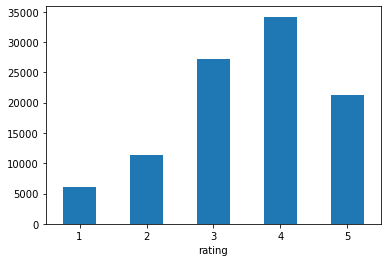

In [12]:
df_all_ratings.groupby('rating')['rating'].count().plot(kind='bar', rot=0);

In [13]:
# ratings
df_all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

### Add Popularity

In [14]:
popularity = df_all_ratings.groupby('item_id').size().reset_index(name='popularity')

Enrich the ratings data with the popularity as an additional metadata.

In [15]:
df_all_ratings = pd.merge(df_all_ratings, popularity)
df_all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp,popularity
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532,452
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088,452
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411,452
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426,452
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324,452


In [16]:
df_all_ratings.nlargest(10, 'popularity')

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp,popularity
6402,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,290,5,880473582,583
6403,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,79,4,891271545,583
6404,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,2,5,888552084,583
6405,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,8,5,879362124,583
6406,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,274,5,878944679,583
6407,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,227,4,879035347,583
6408,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,99,5,885679998,583
6409,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,305,5,886321799,583
6410,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,108,4,879879739,583
6411,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,63,4,875747292,583


Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

### Train Test Validation Split

In [17]:
# Split All ratings into train_val and test
ratings_train_val, ratings_test = train_test_split(df_all_ratings, test_size=0.2, random_state=0)
# Split train_val into training and validation set
ratings_train, ratings_val = train_test_split(ratings_train_val, test_size=0.2, random_state=0)

print('Total rating rows count: {0} '.format(len(df_all_ratings)))
print('Total training rows count: {0} '.format(len(ratings_train_val)))
print('Total validation rows count: {0} '.format(len(ratings_val)))
print('Total test rows count: {0} '.format(len(ratings_test)))


Total rating rows count: 100000 
Total training rows count: 80000 
Total validation rows count: 16000 
Total test rows count: 20000 


In [18]:
ratings_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 39110 to 59493
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             64000 non-null  int64  
 1   title               64000 non-null  object 
 2   release_date        63995 non-null  object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            63992 non-null  object 
 5   release_year        64000 non-null  int64  
 6   user_id             64000 non-null  int64  
 7   rating              64000 non-null  int64  
 8   timestamp           64000 non-null  int64  
 9   popularity          64000 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 5.4+ MB


# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

![alt text](images/rec_archi_1.svg "Title")


### Matrix Factorization

In [19]:
embedding_size = 30 # embedding size
reg_param = 0.01 # regularization parameter lambda
learning_rate = 0.01 # learning rate 


# create tensorflow graph
g = tf.Graph()
with g.as_default():
    # setting up random seed
    tf.set_random_seed(1234)
    
    # placeholders
    users = tf.placeholder(shape=[None], dtype=tf.int64)
    items = tf.placeholder(shape=[None], dtype=tf.int64)
    ratings = tf.placeholder(shape=[None], dtype=tf.float32)
    
    # variables
    with tf.variable_scope("embedding"):
        user_weight = tf.get_variable("user_w"
                                      , shape=[max_user_id + 1, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())

        item_weight = tf.get_variable("item_w"
                                       , shape=[max_item_id + 1, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
    # prediction
    with tf.name_scope("inference"):
        user_embedding = tf.nn.embedding_lookup(user_weight, users)
        item_embedding = tf.nn.embedding_lookup(item_weight, items)
        pred = tf.reduce_sum(tf.multiply(user_embedding, item_embedding), 1) 
        
    # loss 
    with tf.name_scope("loss"):
        reg_loss = tf.contrib.layers.apply_regularization(layers.l2_regularizer(scale=reg_param),
                                               weights_list=[user_weight, item_weight])
        loss = tf.nn.l2_loss(pred - ratings) + reg_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:

def train_model():
    # Training 
    epochs = 1000 # number of iterations 
    losses_train = []
    losses_val = []



    with tf.Session(graph=g) as sess:
        # initializer
        sess.run(tf.global_variables_initializer())


        train_input_dict = {  users: ratings_train['user_id']
                            , items: ratings_train['item_id']
                            , ratings: ratings_train['rating']}
        val_input_dict =  {  users: ratings_val['user_id']
                            , items: ratings_val['item_id']
                            , ratings: ratings_val['rating']}

        test_input_dict =  {  users: ratings_test['user_id']
                            , items: ratings_test['item_id']
                            , ratings: ratings_test['rating']}

        def check_overfit(validation_loss):
            n = len(validation_loss)
            if n < 5:
                return False
            count = 0 
            for i in range(n-4, n):
                if validation_loss[i] < validation_loss[i-1]:
                    count += 1
                if count >=2:
                    return False
            return True

        for i in range(epochs):
            # run the training operation
            sess.run([train_ops], feed_dict=train_input_dict)

            # show intermediate results 
            if i % 5 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)


                # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break

                print("iteration : {0} train loss: {1:.3f} , valid loss {2:.3f}".format(i,loss_train, loss_val))

        # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))

        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        #plt.ylim(0, 50000)
        plt.legend(loc='best')
        plt.title('Loss');

iteration : 0 train loss: 438955.062 , valid loss 109274.805
iteration : 5 train loss: 430119.375 , valid loss 107681.445
iteration : 10 train loss: 401145.875 , valid loss 100981.695
iteration : 15 train loss: 345096.281 , valid loss 87444.453
iteration : 20 train loss: 262872.250 , valid loss 67228.492
iteration : 25 train loss: 166455.234 , valid loss 43223.109
iteration : 30 train loss: 81420.047 , valid loss 21761.318
iteration : 35 train loss: 38146.664 , valid loss 10548.826
iteration : 40 train loss: 37472.969 , valid loss 10132.516
iteration : 45 train loss: 39926.750 , valid loss 10855.713
iteration : 50 train loss: 31300.887 , valid loss 9038.131
iteration : 55 train loss: 25830.363 , valid loss 8010.939
iteration : 60 train loss: 25812.857 , valid loss 8221.631
iteration : 65 train loss: 25626.348 , valid loss 8261.292
iteration : 70 train loss: 24081.348 , valid loss 7883.967
iteration : 75 train loss: 22998.742 , valid loss 7608.098
iteration : 80 train loss: 22692.930 , 

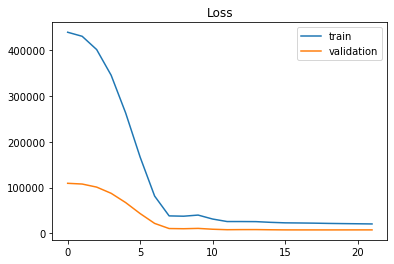

In [21]:
train_model()

### Matrix Factorization with Biases

In [22]:
embedding_size = 30 # embedding size
reg_param = 0.01 # regularization parameter lambda
learning_rate = 0.01 # learning rate 


# create tensorflow graph
g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(1234)
    
    # placeholders
    users = tf.placeholder(shape=[None], dtype=tf.int64)
    items = tf.placeholder(shape=[None], dtype=tf.int64)
    ratings = tf.placeholder(shape=[None], dtype=tf.float32)
    
    # variables
    with tf.variable_scope("embedding"):
        user_weight = tf.get_variable("user_w"
                                      , shape=[max_user_id + 1, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())

        item_weight = tf.get_variable("item_w"
                                       , shape=[max_item_id + 1, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        user_bias = tf.get_variable("user_b"
                                , shape=[max_user_id + 1]
                                , dtype=tf.float32
                                , initializer=tf.zeros_initializer)
        
        item_bias = tf.get_variable("item_b"
                                 , shape=[max_item_id + 1]
                                 , dtype=tf.float32
                                 , initializer=tf.zeros_initializer)
        
    # prediction
    with tf.name_scope("inference"):
        user_embedding = tf.nn.embedding_lookup(user_weight, users)
        item_embedding = tf.nn.embedding_lookup(item_weight, items)
        user_b = tf.nn.embedding_lookup(user_bias, users)
        item_b = tf.nn.embedding_lookup(item_bias, items)
        pred = tf.reduce_sum(tf.multiply(user_embedding, item_embedding), 1) + user_b + item_b
        
    # loss 
    with tf.name_scope("loss"):
        reg_loss = tf.contrib.layers.apply_regularization(layers.l2_regularizer(scale=reg_param),
                                               weights_list=[user_weight, item_weight])
        loss = tf.nn.l2_loss(pred - ratings) + reg_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

   

iteration : 0 train loss: 434451.188 , valid loss 108152.555
iteration : 5 train loss: 403790.656 , valid loss 101102.711
iteration : 10 train loss: 355479.656 , valid loss 89540.078
iteration : 15 train loss: 285449.781 , valid loss 72448.688
iteration : 20 train loss: 198575.859 , valid loss 50982.105
iteration : 25 train loss: 111163.320 , valid loss 29129.332
iteration : 30 train loss: 50093.465 , valid loss 13611.054
iteration : 35 train loss: 33727.254 , valid loss 9234.546
iteration : 40 train loss: 38895.711 , valid loss 10511.692
iteration : 45 train loss: 34300.270 , valid loss 9630.750
iteration : 50 train loss: 26736.699 , valid loss 8091.477
iteration : 55 train loss: 25132.514 , valid loss 7959.960
iteration : 60 train loss: 25422.406 , valid loss 8179.477
iteration : 65 train loss: 24283.764 , valid loss 7953.402
iteration : 70 train loss: 22859.633 , valid loss 7620.200
iteration : 75 train loss: 22283.584 , valid loss 7516.659
iteration : 80 train loss: 21930.391 , val

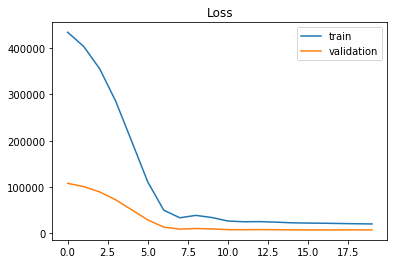

In [23]:
train_model()

## A Deep recommender model

We can use deep learning models with multiple layers ( fully connected and dropout ) for the recommendation system.

![alt text](images/rec_archi_2.svg "Title")


To build this model we will need a new kind of layer:

In [24]:
embedding_size = 50
reg_param = 0.01
learning_rate = 0.01
n_users = max_user_id + 1
n_items = max_item_id + 1

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(1234)

    users = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_users')
    items = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_items')
    ratings = tf.placeholder(shape=[None,1], dtype=tf.float32, name='input_ratings')
    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, users),axis=1, name='user_embedding')
        item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, items),axis=1, name='item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        input_vecs = tf.concat([user_embedding, item_embedding], axis=1)
        print(input_vecs)
        
    # fc-1
    num_hidden = 64
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[2*embedding_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output = tf.nn.relu(tf.nn.xw_plus_b(input_vecs, W_fc_1, b_fc_1), name='hidden_output')
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output)
        
    # dropout
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(hidden_output, 0.99, name="hidden_output_drop")
        print(h_drop)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        pred = tf.nn.xw_plus_b(h_drop, W_fc_2, b_fc_2, name='pred')
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(pred)

    # loss
    with tf.name_scope("loss"):
        loss = tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

        

Tensor("embedding/user_embedding:0", shape=(?, 50), dtype=float32)
Tensor("embedding/item_embedding:0", shape=(?, 50), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 100), dtype=float32)
Tensor("fc_1/hidden_output:0", shape=(?, 64), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/hidden_output_drop/mul:0", shape=(?, 64), dtype=float32)
Tensor("fc_2/pred:0", shape=(?, 1), dtype=float32)


In [25]:
def train_model_deep():
    losses_train = []
    losses_val = []
    epochs = 1000

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        train_input_dict = {users: ratings_train['user_id'].values.reshape([-1,1])
            , items: ratings_train['item_id'].values.reshape([-1,1])
            , ratings: ratings_train['rating'].values.reshape([-1,1])}

        val_input_dict = {users: ratings_val['user_id'].values.reshape([-1,1])
            , items: ratings_val['item_id'].values.reshape([-1,1])
            , ratings: ratings_val['rating'].values.reshape([-1,1])}

        test_input_dict = {users: ratings_test['user_id'].values.reshape([-1,1])
            , items: ratings_test['item_id'].values.reshape([-1,1])
            , ratings: ratings_test['rating'].values.reshape([-1,1])}

        def check_overfit(validation_loss):
                n = len(validation_loss)
                if n < 5:
                    return False
                count = 0 
                for i in range(n-4, n):
                    if validation_loss[i] < validation_loss[i-1]:
                        count += 1
                    if count >=3:
                        return False
                return True



        for i in range(epochs):
            sess.run([train_ops], feed_dict=train_input_dict)
            if i % 10 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)

                # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break

                print("iteration : %d train loss: %.3f , valid loss %.3f" % (i,loss_train, loss_val))

         # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))

        # user and item embedding
        user_embedding_variable = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('embedding/user_w:0')][0]
        item_embedding_variable = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('embedding/item_w:0')][0]
        user_embedding_weights, item_embedding_weights = sess.run([user_embedding_variable,item_embedding_variable])
        
        
        # plot train and validation loss
        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        plt.legend(loc='best')
        plt.title('Loss');
        
        return user_embedding_weights, item_embedding_weights 

iteration : 0 train loss: 320585.312 , valid loss 79709.352
iteration : 10 train loss: 39800.684 , valid loss 10547.440
iteration : 20 train loss: 29583.850 , valid loss 7995.043
iteration : 30 train loss: 26737.551 , valid loss 7325.980
iteration : 40 train loss: 27131.520 , valid loss 7464.453
iteration : 50 train loss: 27056.305 , valid loss 7344.873
iteration : 60 train loss: 26558.799 , valid loss 7308.701
iteration : 70 train loss: 26373.887 , valid loss 7251.662
iteration : 80 train loss: 26401.137 , valid loss 7239.429
iteration : 90 train loss: 26333.916 , valid loss 7255.240
overfit !
RMSE on test dataset : 0.9466


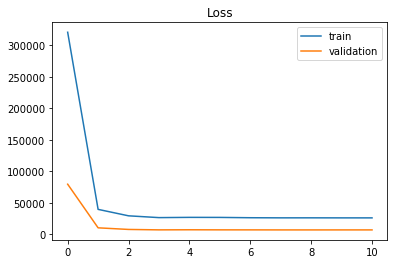

In [26]:
user_embedding_weights, item_embedding_weights  = train_model_deep()

### Model Embeddings

In [27]:
print("First item name from metadata:", df_items["title"][1])
print("Embedding vector for the first item:")
print(item_embedding_weights[1])
print("shape:", item_embedding_weights[1].shape)

First item name from metadata: GoldenEye (1995)
Embedding vector for the first item:
[-8.13292265e-02  1.29369408e-01  2.64590010e-02  7.25499168e-02
  9.46553797e-02 -2.34591458e-02  1.44561410e-01 -2.16630697e-02
 -1.14813708e-01  8.92936662e-02  8.70991349e-02  1.05688311e-01
 -7.13586435e-03 -2.75054071e-02 -5.57548692e-03 -6.14384152e-02
  1.26213551e-01  1.20054789e-01 -8.70618224e-02  6.84661046e-02
  7.70659372e-02 -1.19550332e-01  4.52612005e-02  5.84997833e-02
 -1.02689154e-01  1.73030198e-02 -1.84801102e-05  1.31064892e-01
  6.11303025e-04 -1.77407395e-02  3.64360306e-03 -5.01708873e-02
 -5.93916606e-03  4.39359210e-02  9.71281901e-02 -3.98783721e-02
 -1.21433638e-01 -3.64338122e-02 -1.09553069e-01 -1.31979600e-01
 -2.26403773e-02  1.86700970e-02 -2.10604575e-02 -3.03335655e-02
 -4.23979163e-02 -8.66299346e-02  9.93846580e-02 -6.44636527e-02
 -7.07887784e-02 -9.25129727e-02]
shape: (50,)


### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- check what is the impact of different perplexity value. Here is a very nice tutorial if you want to know in detail (https://distill.pub/2016/misread-tsne/ )

In [28]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=50).fit_transform(item_embedding_weights)

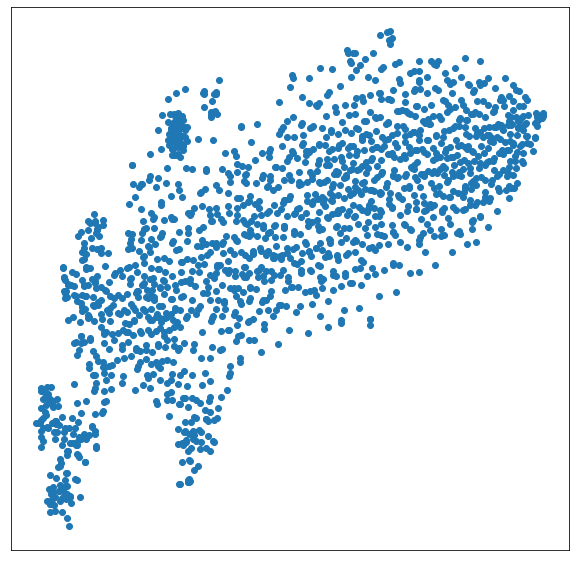

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.



![alt text](images/rec_archi_3.svg "Title")

In [30]:
embedding_size = 50
reg_param = 0.01
learning_rate = 0.01
n_users = max_user_id + 1
n_items = max_item_id + 1
meta_size = 2

g = tf.Graph()
with g.as_default():

    tf.set_random_seed(1234)
    
    users = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_users')
    items = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_items')
    meta = tf.placeholder(shape=[None,2], dtype=tf.float32, name='input_metadata')
    ratings = tf.placeholder(shape=[None,1], dtype=tf.float32, name='input_ratings')
    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, users),axis=1, name='user_embedding')
        item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, items),axis=1, name='item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        input_vecs = tf.concat([user_embedding, item_embedding, meta], axis=1)
        print(input_vecs)
        
    # fc-1
    num_hidden = 64
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[2*embedding_size + meta_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output = tf.nn.relu(tf.nn.xw_plus_b(input_vecs, W_fc_1, b_fc_1), name='hidden_output')
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output)
    
    # dropout
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(hidden_output, 0.99, name="hidden_output_drop")
        print(h_drop)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        pred = tf.nn.xw_plus_b(h_drop, W_fc_2, b_fc_2, name='pred')
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(pred)

    # loss
    with tf.name_scope("loss"):
        loss = tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

Tensor("embedding/user_embedding:0", shape=(?, 50), dtype=float32)
Tensor("embedding/item_embedding:0", shape=(?, 50), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 102), dtype=float32)
Tensor("fc_1/hidden_output:0", shape=(?, 64), dtype=float32)
Tensor("dropout/hidden_output_drop/mul:0", shape=(?, 64), dtype=float32)
Tensor("fc_2/pred:0", shape=(?, 1), dtype=float32)


In [31]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_val = scaler.transform(ratings_val[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [32]:
def train_model_deep_meta():

    losses_train = []
    losses_val = []
    epochs = 1000

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        train_input_dict = {users: ratings_train['user_id'].values.reshape([-1,1])
            , items: ratings_train['item_id'].values.reshape([-1,1])
            , ratings: ratings_train['rating'].values.reshape([-1,1])
                           ,meta: item_meta_train}

        val_input_dict = {users: ratings_val['user_id'].values.reshape([-1,1])
            , items: ratings_val['item_id'].values.reshape([-1,1])
            , ratings: ratings_val['rating'].values.reshape([-1,1])
                         ,meta : item_meta_val}

        test_input_dict = {users: ratings_test['user_id'].values.reshape([-1,1])
            , items: ratings_test['item_id'].values.reshape([-1,1])
            , ratings: ratings_test['rating'].values.reshape([-1,1])
                          ,meta : item_meta_test}
        def check_overfit(validation_loss):
            n = len(validation_loss)
            if n < 5:
                return False
            count = 0 
            for i in range(n-4, n):
                if validation_loss[i] < validation_loss[i-1]:
                    count += 1
                if count >=3:
                    return False
            return True


        for i in range(epochs):
            sess.run([train_ops], feed_dict=train_input_dict)
            if i % 10 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)

                 # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break
                print("iteration : %d train loss: %.3f , valid loss %.3f" % (i,loss_train, loss_val))
        
        # plot train and validation loss
        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        plt.legend(loc='best')
        plt.title('Loss');
        
         # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))
        

iteration : 0 train loss: 393687.219 , valid loss 97932.086
iteration : 10 train loss: 58525.973 , valid loss 15254.022
iteration : 20 train loss: 36474.438 , valid loss 9531.139
iteration : 30 train loss: 28394.703 , valid loss 7859.956
iteration : 40 train loss: 26916.246 , valid loss 7353.238
iteration : 50 train loss: 26480.629 , valid loss 7270.163
iteration : 60 train loss: 26482.893 , valid loss 7298.847
iteration : 70 train loss: 26471.447 , valid loss 7258.732
overfit !
RMSE on test dataset : 0.9484


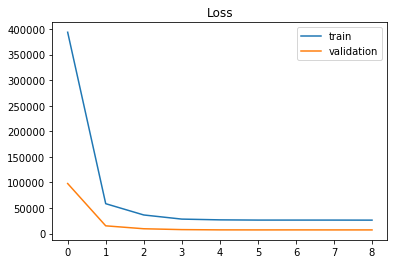

In [33]:
train_model_deep_meta()